In [1]:
!pip install tensorflow-gpu

In [2]:
!pip install gdown

In [3]:
!pip install imbalanced-learn

In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
!gdown --id 18gwvNkMs6t0jL0APl9iWPrhr5GVg082S --output insurance_claim_prediction.csv

Downloading...
From: https://drive.google.com/uc?id=18gwvNkMs6t0jL0APl9iWPrhr5GVg082S
To: /content/insurance_claim_prediction.csv
116MB [00:00, 174MB/s]


In [0]:
df = pd.read_csv('insurance_claim_prediction.csv')

In [7]:
print(df.shape)

(595212, 59)


In [8]:
df.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [0]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

In [10]:
no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

No claim 573518
Claim 21694
Claim proportion 3.64%


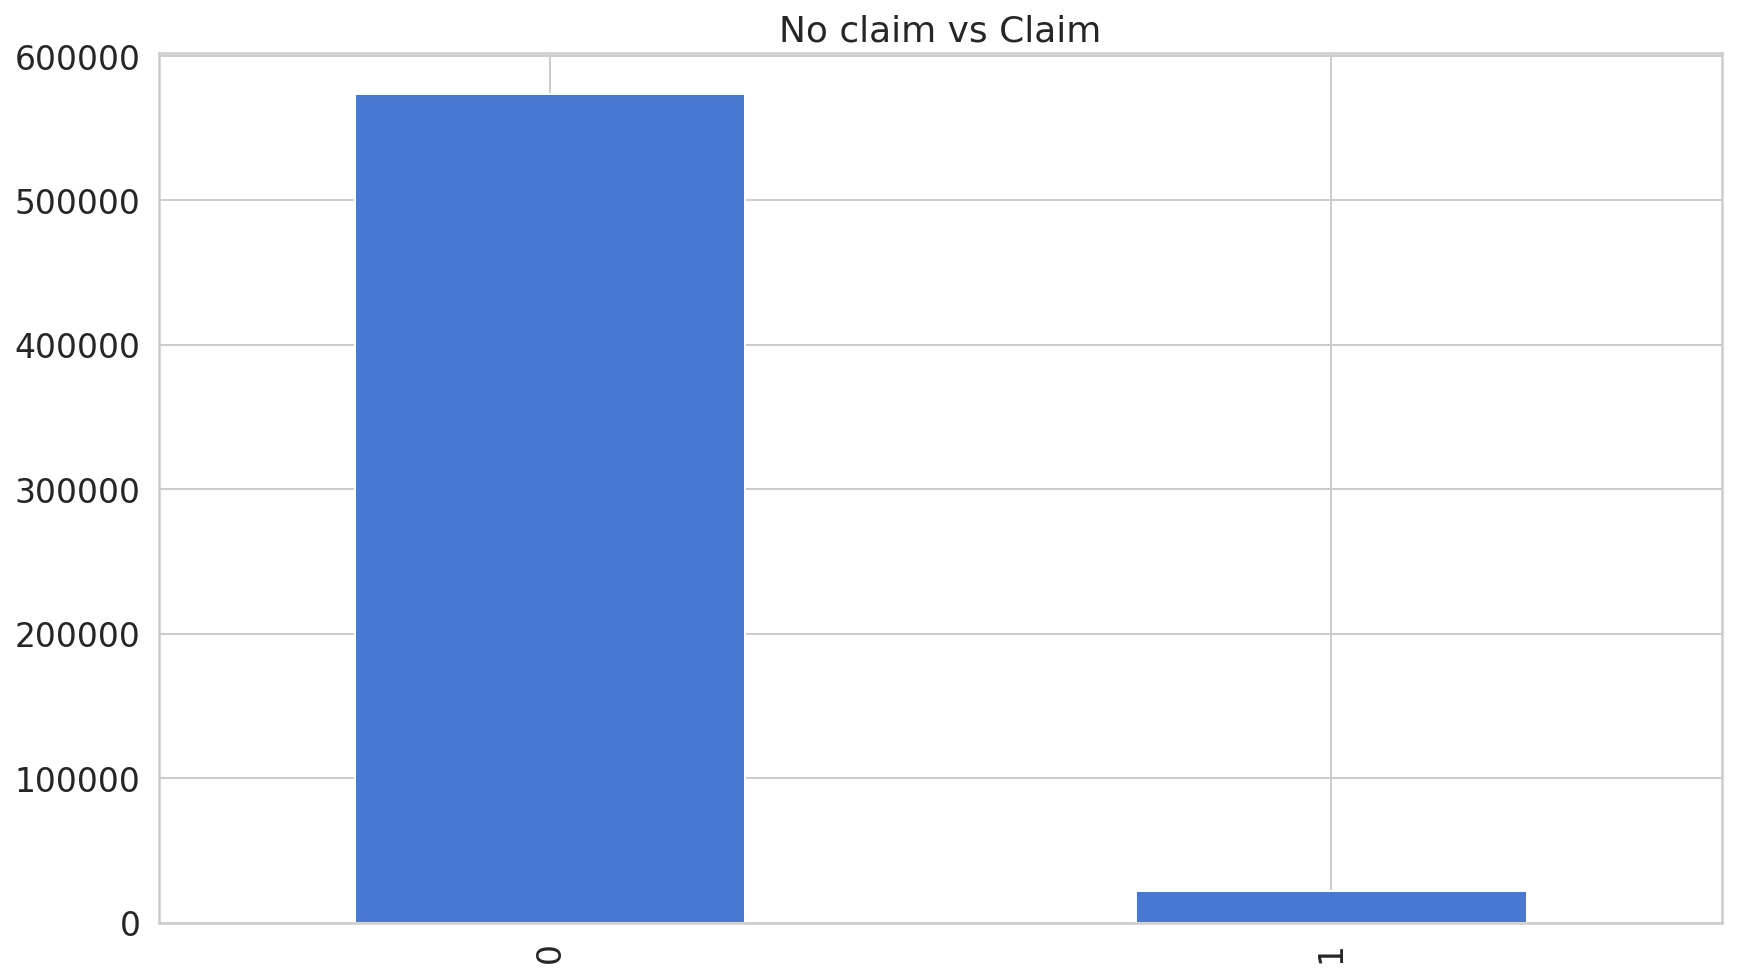

In [11]:
df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

# Data preprocessing

## Missing values

In [12]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

ps_ind_02_cat - 216 (0.036%) rows missing
ps_ind_04_cat - 83 (0.014%) rows missing
ps_ind_05_cat - 5809 (0.976%) rows missing
ps_reg_03 - 107772 (18.106%) rows missing
ps_car_01_cat - 107 (0.018%) rows missing
ps_car_02_cat - 5 (0.001%) rows missing
ps_car_03_cat - 411231 (69.09%) rows missing
ps_car_05_cat - 266551 (44.783%) rows missing
ps_car_07_cat - 11489 (1.93%) rows missing
ps_car_09_cat - 569 (0.096%) rows missing
ps_car_11 - 5 (0.001%) rows missing
ps_car_12 - 1 (0.0%) rows missing
ps_car_14 - 42620 (7.16%) rows missing


In [0]:
df.drop(["ps_car_03_cat", "ps_car_05_cat", "ps_reg_03"], inplace=True, axis=1)

In [0]:
from sklearn.impute import SimpleImputer

cat_columns = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_07_cat', 'ps_car_09_cat']
num_columns = ['ps_car_11', 'ps_car_12', 'ps_car_14']

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
cat_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

for c in cat_columns:
  df[c] = cat_imp.fit_transform(df[[c]]).ravel()

for c in num_columns:
  df[c] = mean_imp.fit_transform(df[[c]]).ravel()

## Categorical features

In [0]:
df = pd.get_dummies(df, columns=cat_columns)

# Simple model

In [0]:
from sklearn.model_selection import train_test_split

labels = df.columns[2:]

X = df[labels]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

In [17]:
X_train.shape

(565451, 81)

In [18]:
y_train.shape

(565451,)

In [19]:
X_train.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_car_04_cat,ps_car_06_cat,ps_car_08_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,...,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4
238535,0,1,1,0,0,0,0,0,0,0,0,8,1,0,0,0.4,0.0,0,4,1,1,48,3.0,0.316070,0.511359,0.374691,1.732051,0.1,0.5,0.0,5,2,6,3,11,2,9,5,3,4,...,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
140815,2,1,0,0,0,1,0,0,0,0,0,7,1,0,0,0.7,0.7,0,11,0,1,76,2.0,0.316228,0.887092,0.379473,3.741657,0.4,0.9,0.1,4,3,10,1,10,3,5,1,0,5,...,1,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0
21809,1,10,1,0,0,0,0,0,0,0,0,7,1,0,0,0.6,0.5,0,14,1,1,82,3.0,0.316070,0.516064,0.308221,1.000000,0.4,0.8,0.0,2,2,7,3,11,2,4,6,0,3,...,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
61677,4,8,0,0,1,0,0,0,0,0,0,3,0,1,0,0.4,0.0,0,11,1,1,44,1.0,0.447214,0.663465,0.339116,2.449490,0.6,0.2,0.7,3,1,7,5,9,3,8,1,1,3,...,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0
529955,0,7,1,0,0,0,0,0,0,0,0,11,1,0,0,0.5,0.2,0,11,1,1,44,3.0,0.447214,0.700767,0.339116,2.645751,0.1,0.8,0.6,3,2,6,4,9,2,8,4,1,2,...,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0


In [20]:
y_train.head()

238535    0
140815    0
21809     0
61677     0
529955    0
Name: target, dtype: int64

## Neural Network

In [0]:
def build_model(train_data, metrics=["accuracy"]):
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid'),
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
  )

  return model

In [0]:
model = build_model(X_train)

In [23]:
BATCH_SIZE = 2048

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

In [0]:
def plot_accuracy(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
            label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
            label = 'Val Accuracy')
  plt.ylim((0, 1))
  plt.legend()
  plt.show()

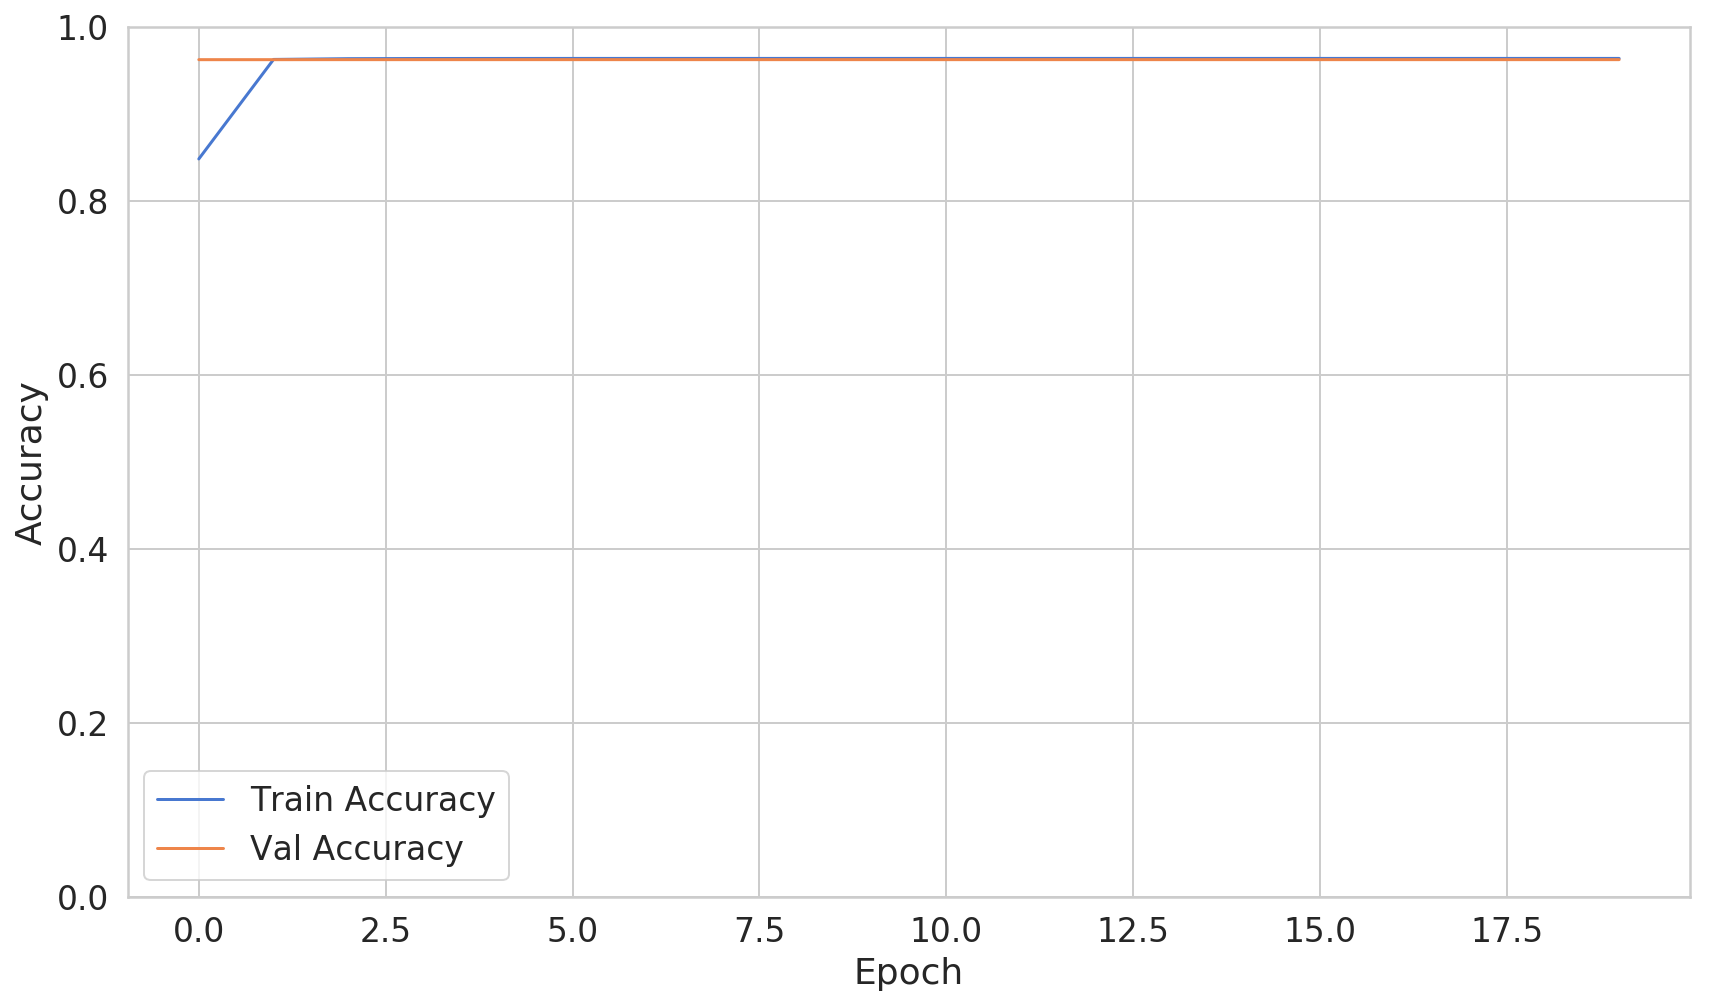

In [25]:
plot_accuracy(history)

In [26]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

29761/29761 [==============================] - 0s 3us/sample - loss: 0.1562 - accuracy: 0.9623


[0.15623768504621008, 0.96233326]

## Dummy model

In [0]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)

In [0]:
y_pred = awesome_model_predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y_test)

0.9623332549309499

# Evaluation

## Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):

  tick_labels = ['No claim', 'Claim']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [31]:
model_pred = model.predict(X_test, batch_size=BATCH_SIZE)

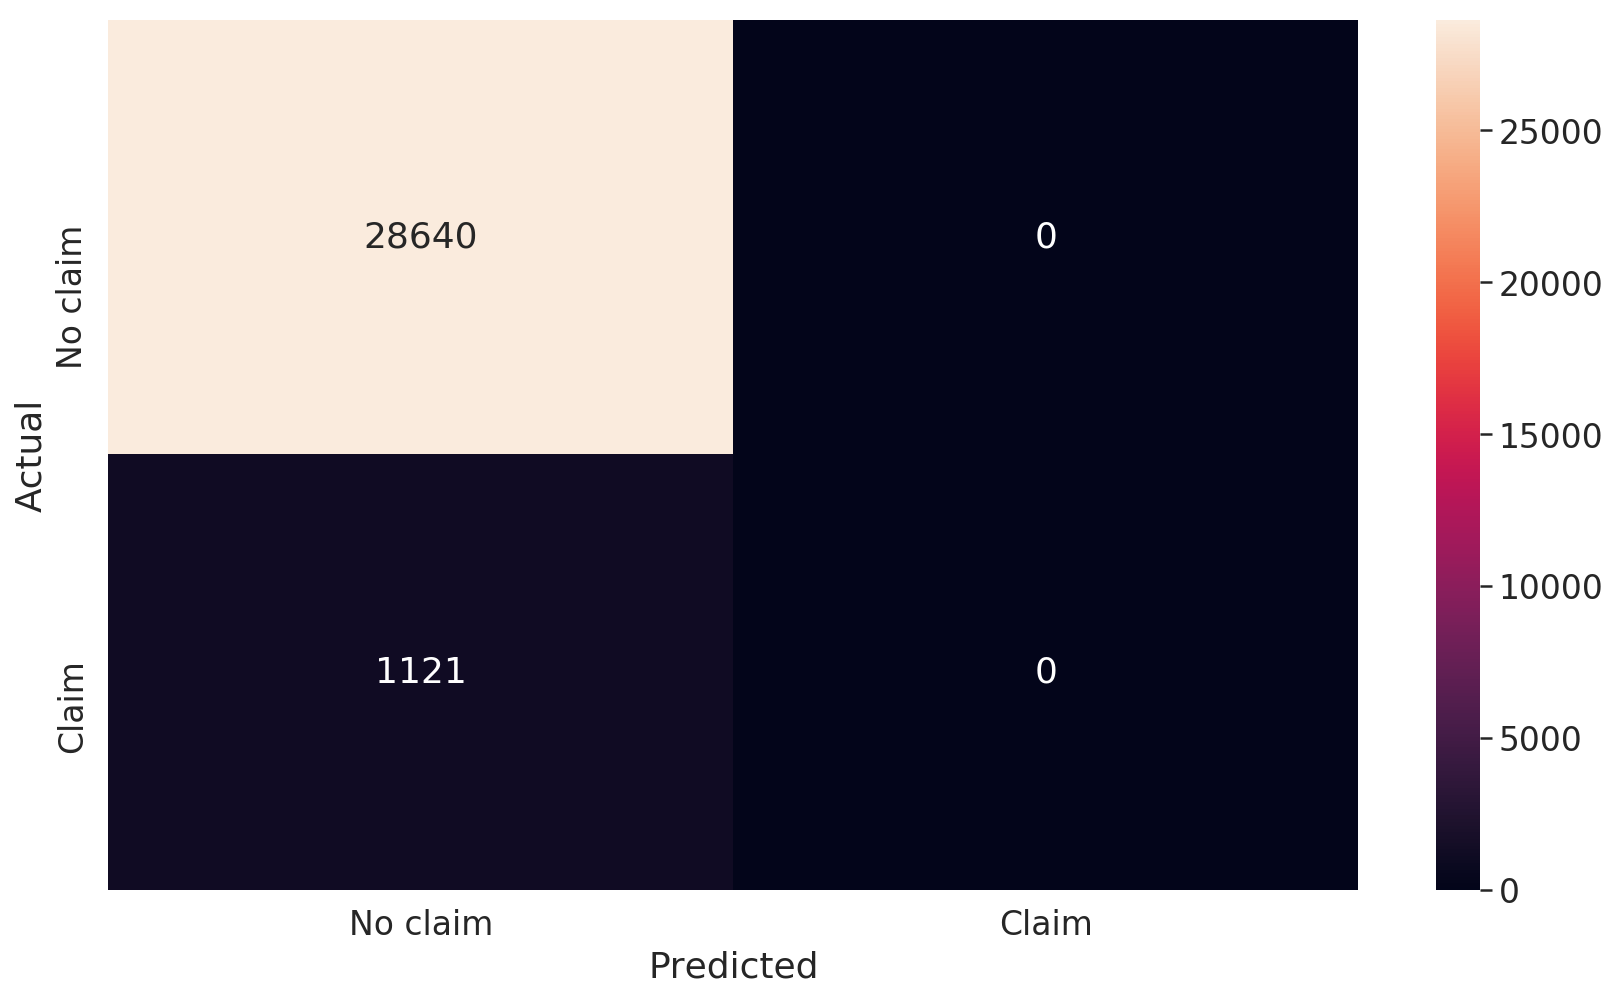

In [32]:
plot_cm(y_test, model_pred)

## More metrics

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [0]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

In [0]:
model = build_model(X_train, metrics=METRICS)

In [36]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

In [37]:
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.1569033651880101
tp :  0.0
fp :  1.0
tn :  28639.0
fn :  1121.0
accuracy :  0.96229964
precision :  0.0
recall :  0.0
auc :  0.62359923
f1 score: 0.0



## ROC curve

In [0]:
from sklearn.metrics import roc_curve

def plot_roc(labels, predictions):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label='ROC', linewidth=3)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(
      [0, 1], [0, 1], 
      linestyle='--', 
      linewidth=2, 
      color='r',
      label='Chance', 
      alpha=.8
  )
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.legend(loc="lower right")

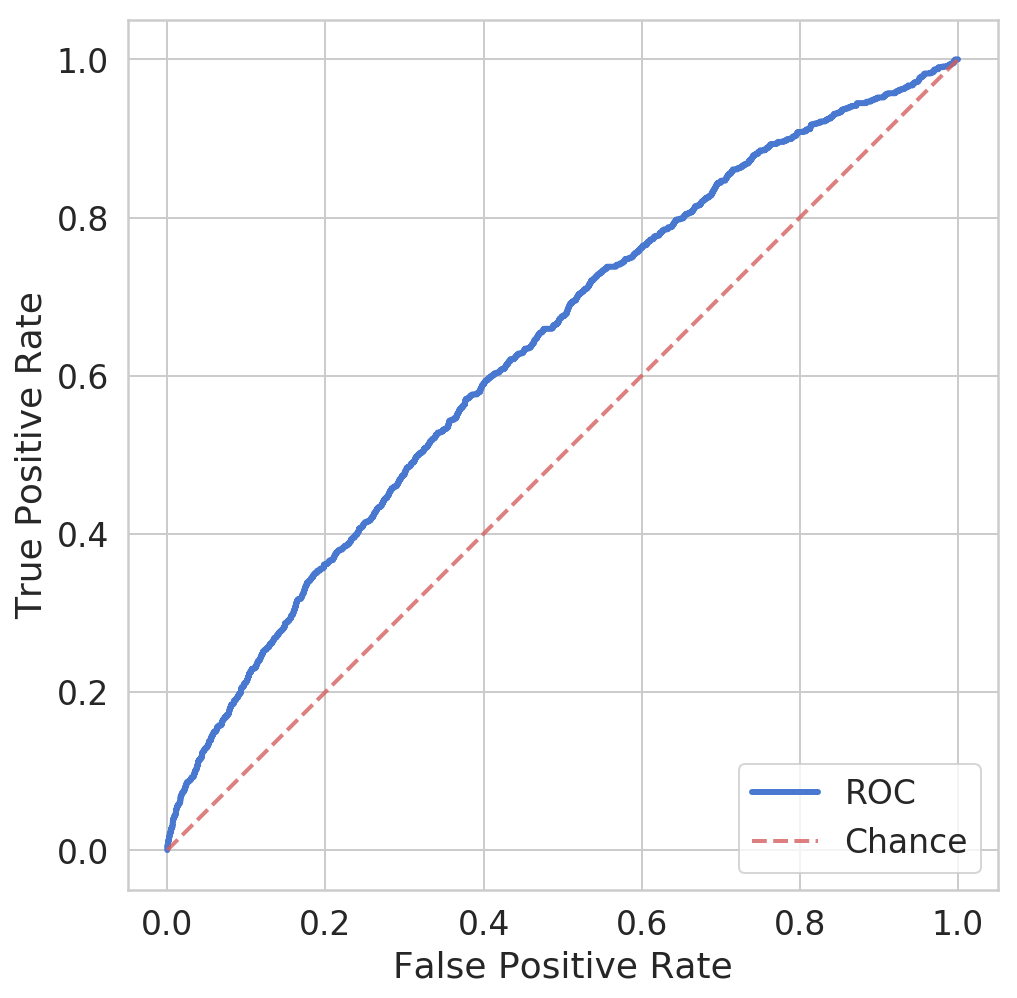

In [39]:
plot_roc(y_test, model_pred)

# Weighted model

In [0]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

In [0]:
weight_no_claim = (1 / no_claim_count) * (total_count) / 2.0 
weight_claim = (1 / claim_count) * (total_count) / 2.0 

class_weights = {0: weight_no_claim, 1: weight_claim}

In [42]:
model = build_model(X_train, metrics=METRICS)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0,
    class_weight=class_weights
)

In [43]:
model_pred = model.predict(X_test, batch_size=BATCH_SIZE)

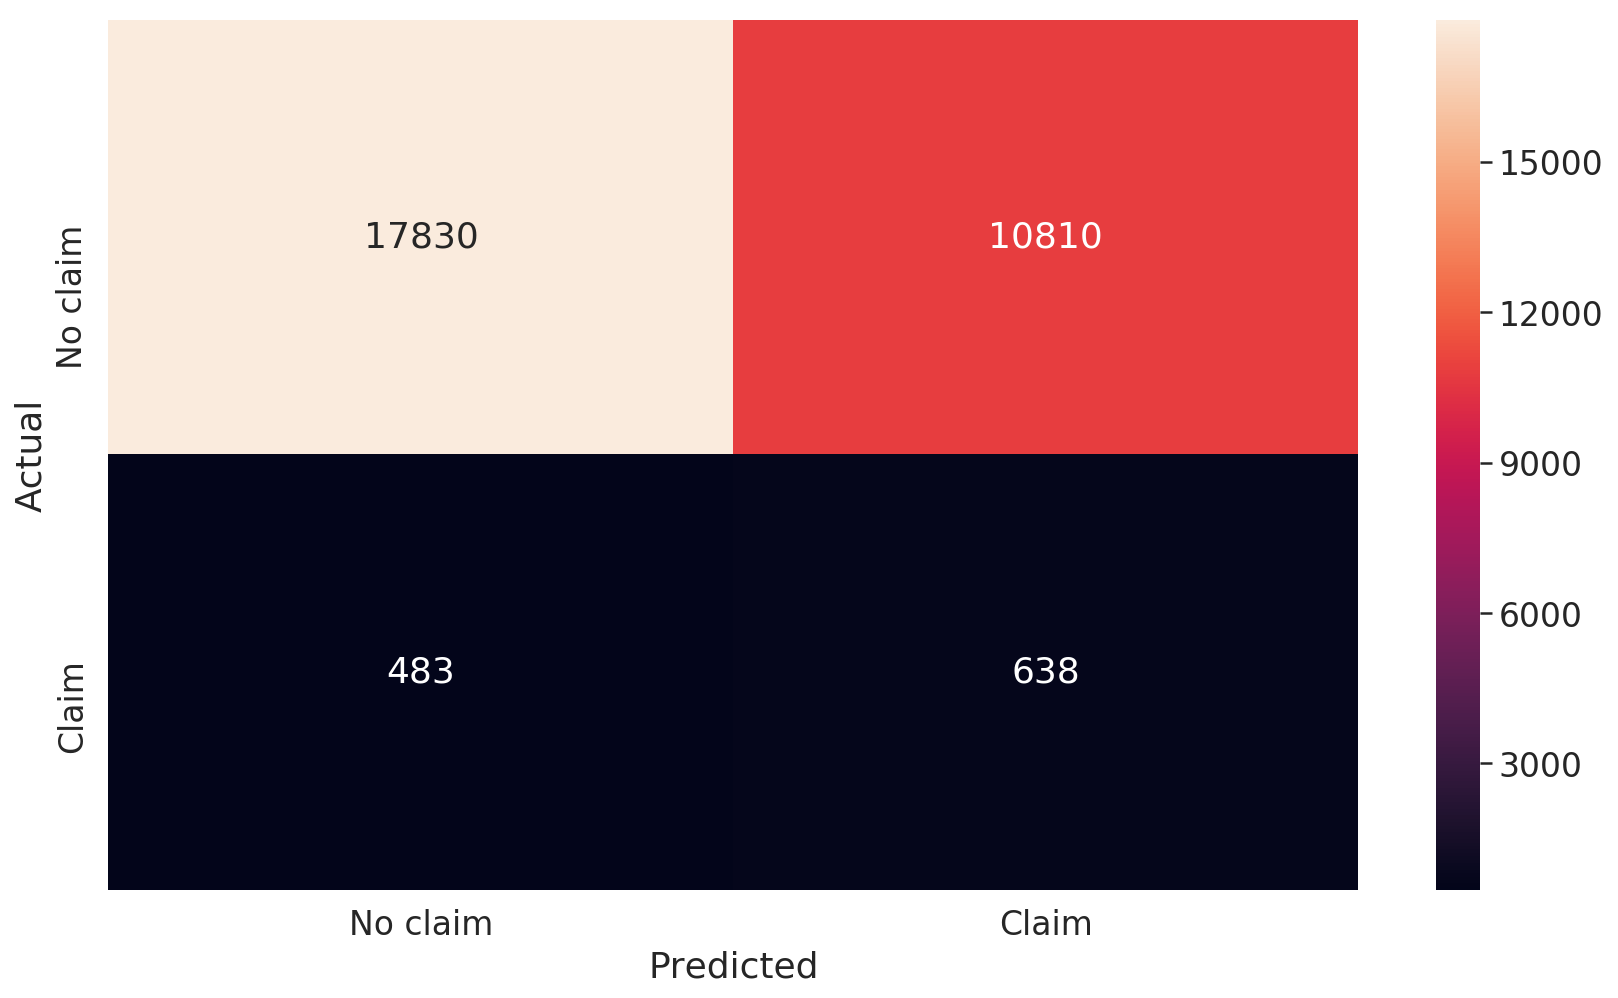

In [44]:
plot_cm(y_test, model_pred)

In [45]:
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.6592857456568576
tp :  638.0
fp :  10810.0
tn :  17830.0
fn :  483.0
accuracy :  0.62054366
precision :  0.055730257
recall :  0.5691347
auc :  0.6299424
f1 score: 0.10151961174317768



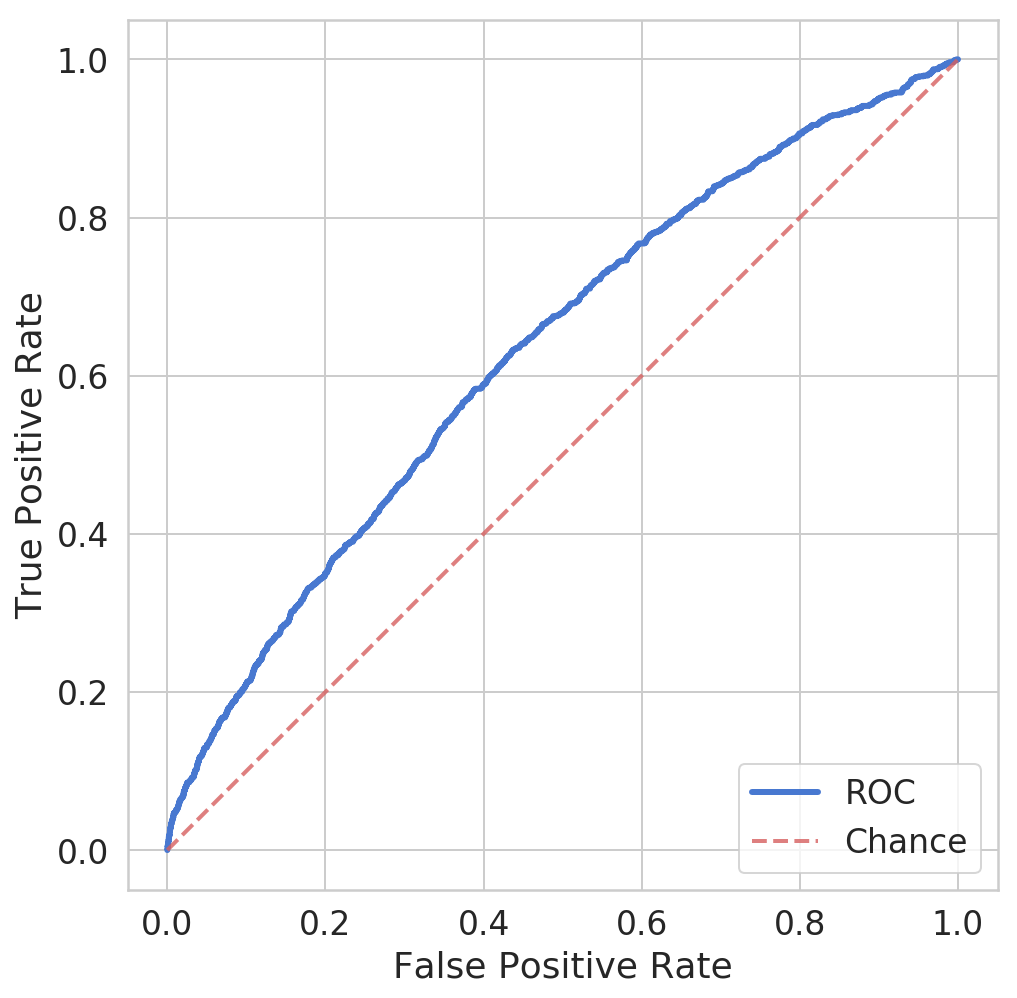

In [46]:
plot_roc(y_test, model_pred)

# Resampling

In [0]:
X = pd.concat([X_train, y_train], axis=1)

no_claim = X[X.target == 0]
claim = X[X.target == 1]

## Oversample minority class

In [0]:
from sklearn.utils import resample

claim_upsampled = resample(claim,
                          replace=True, 
                          n_samples=len(no_claim),
                          random_state=RANDOM_SEED)

In [0]:
upsampled = pd.concat([no_claim, claim_upsampled])

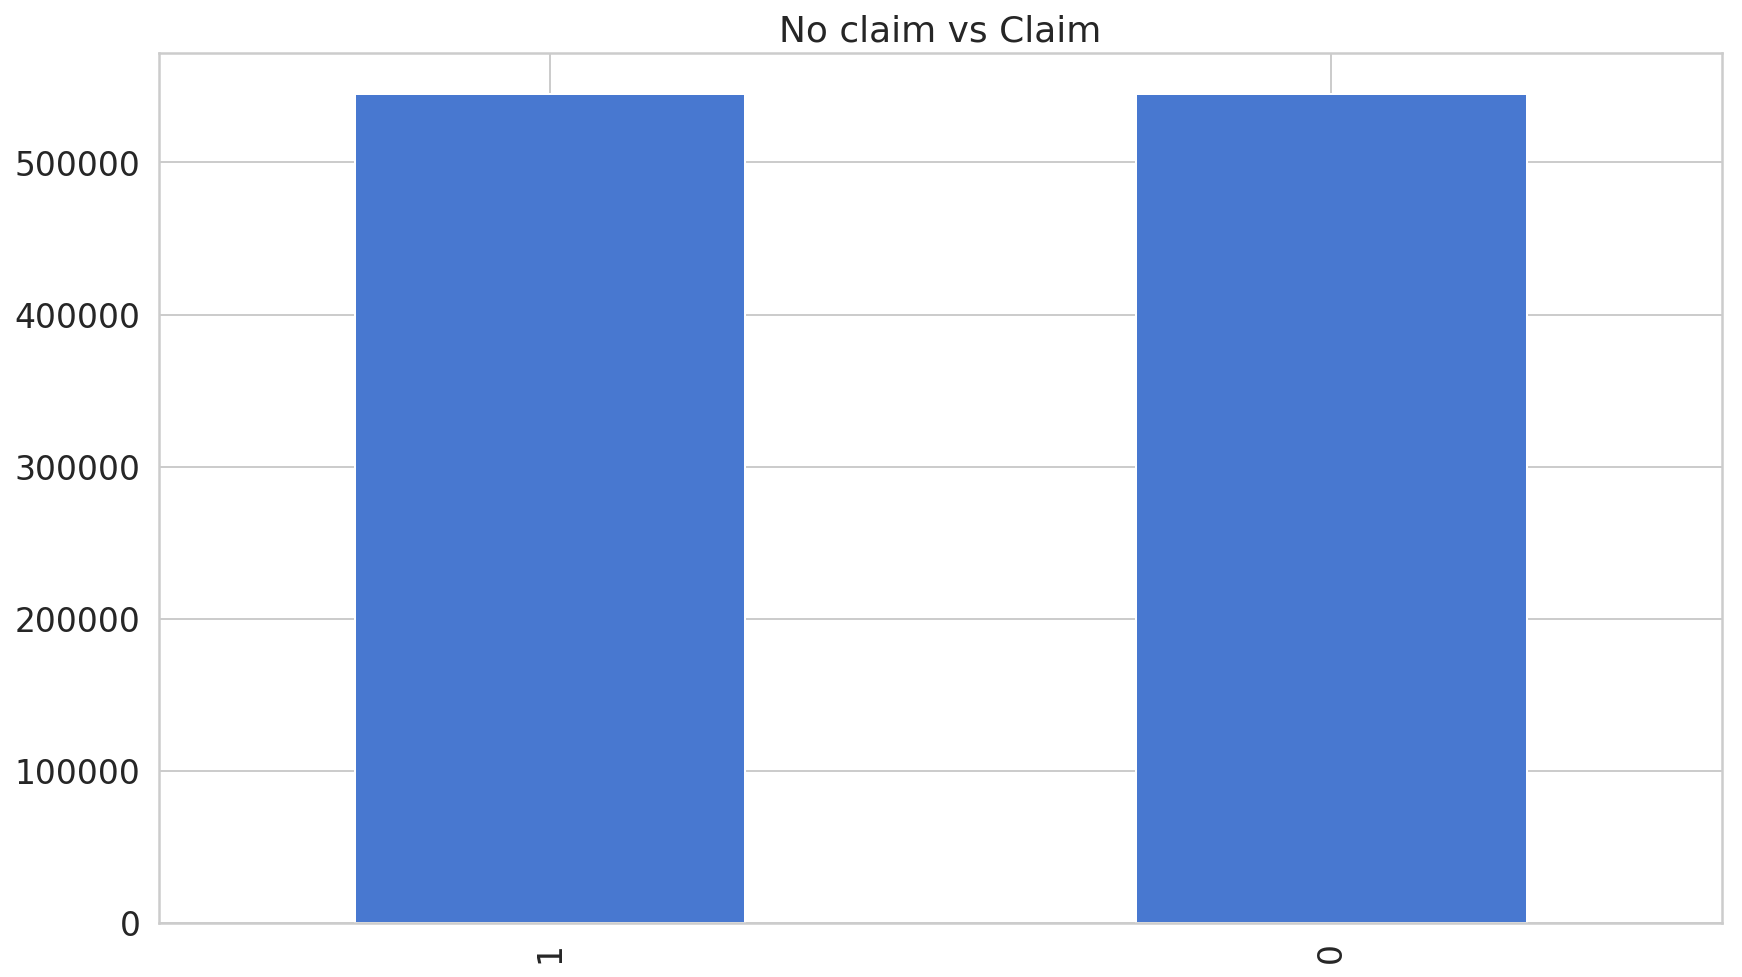

In [50]:
upsampled.target.value_counts().plot(kind="bar", title="No claim vs Claim");

In [0]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [52]:
X_train.shape

(1089756, 81)

In [53]:
y_train.shape

(1089756,)

In [54]:
y_train.head()

238535    0
140815    0
21809     0
61677     0
529955    0
Name: target, dtype: int64

In [55]:
upsampled.shape

(1089756, 82)

In [0]:
model = build_model(X_train, metrics=METRICS)

In [57]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=40,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

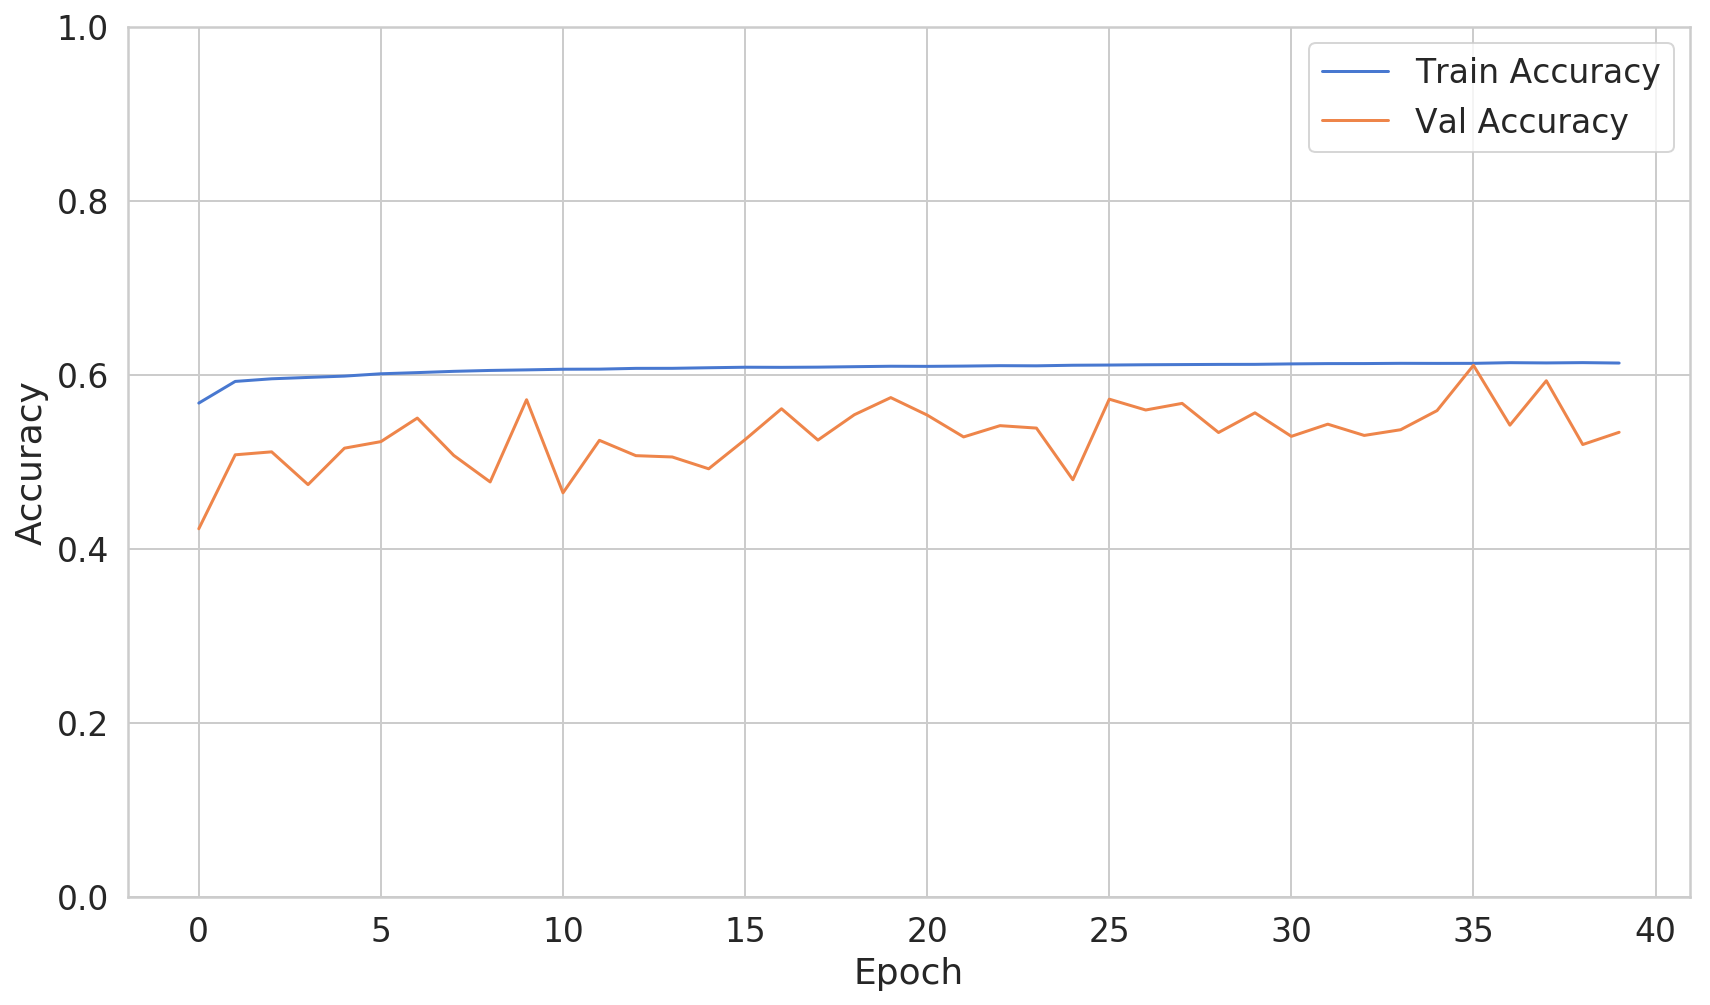

In [58]:
plot_accuracy(history)

In [59]:
model_pred = model.predict(X_test, batch_size=BATCH_SIZE)

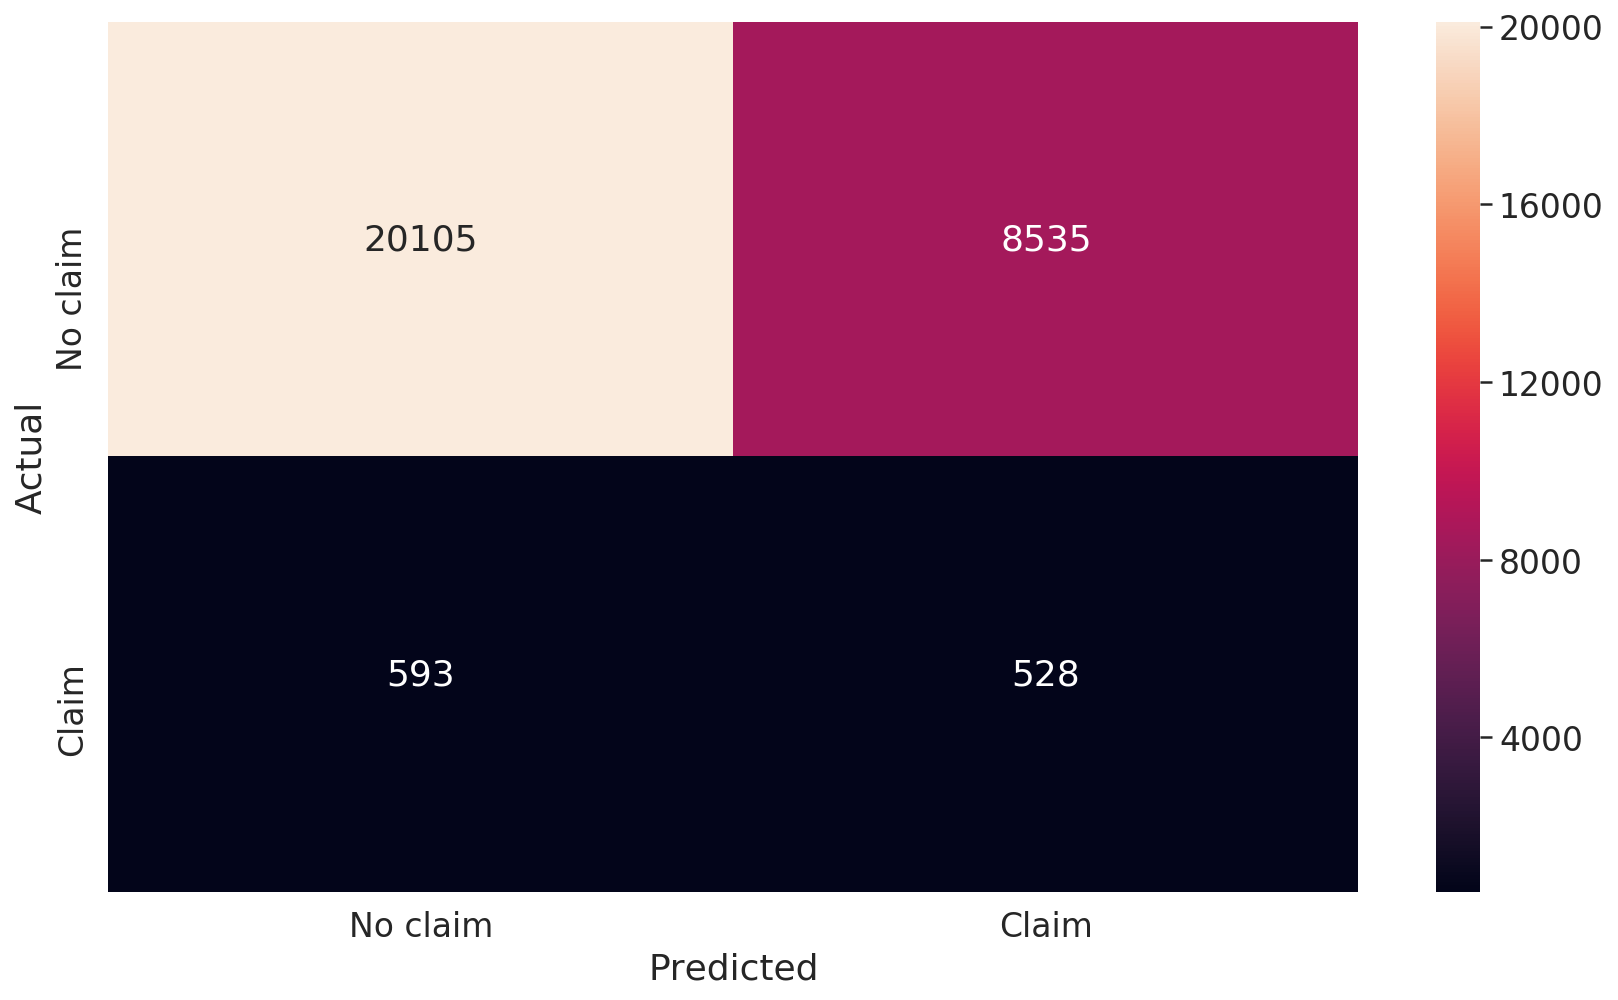

In [60]:
plot_cm(y_test, model_pred)

In [61]:
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.6069594620556797
tp :  528.0
fp :  8535.0
tn :  20105.0
fn :  593.0
accuracy :  0.6932899
precision :  0.058258854
recall :  0.47100803
auc :  0.6237411
f1 score: 0.10369206598586017



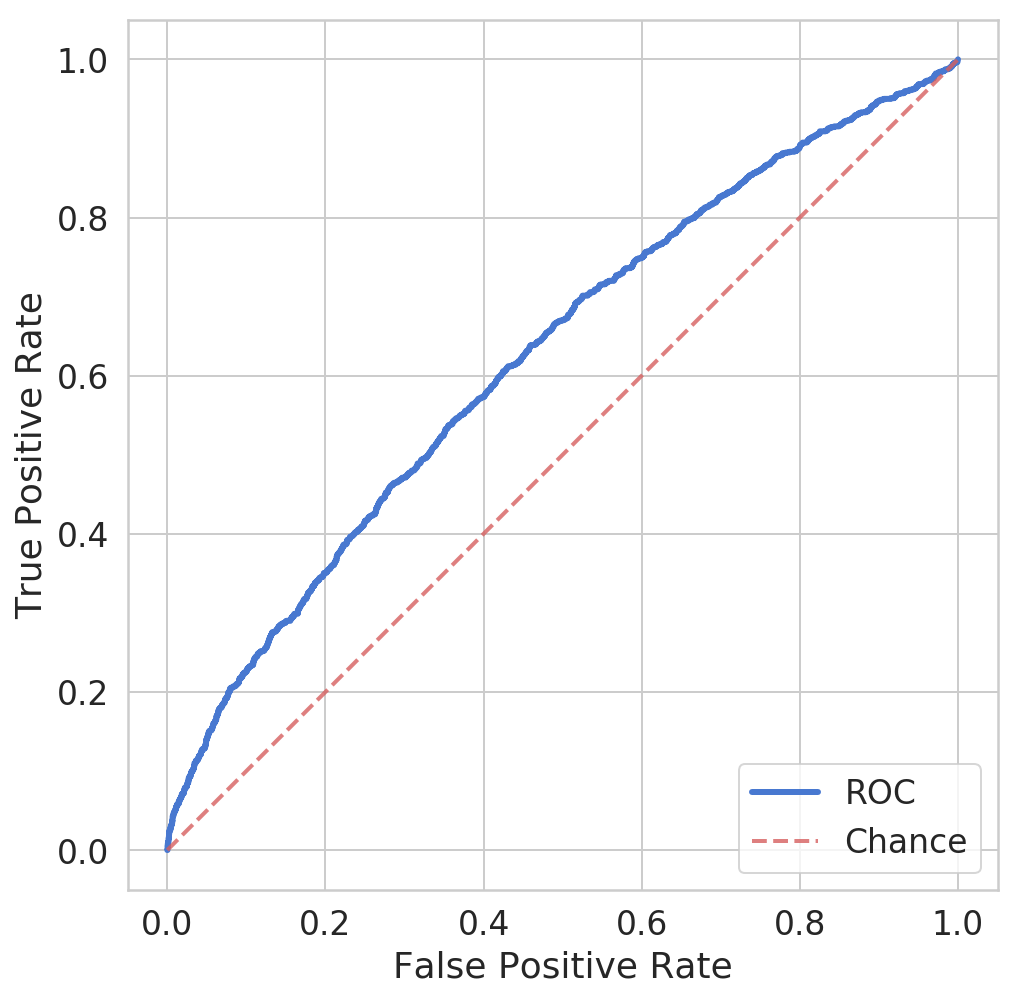

In [62]:
plot_roc(y_test, model_pred)

## Undersample majority class

In [0]:
no_claim_downsampled = resample(no_claim,
                                replace = False,
                                n_samples = len(claim),
                                random_state = RANDOM_SEED)

In [0]:
downsampled = pd.concat([no_claim_downsampled, claim])

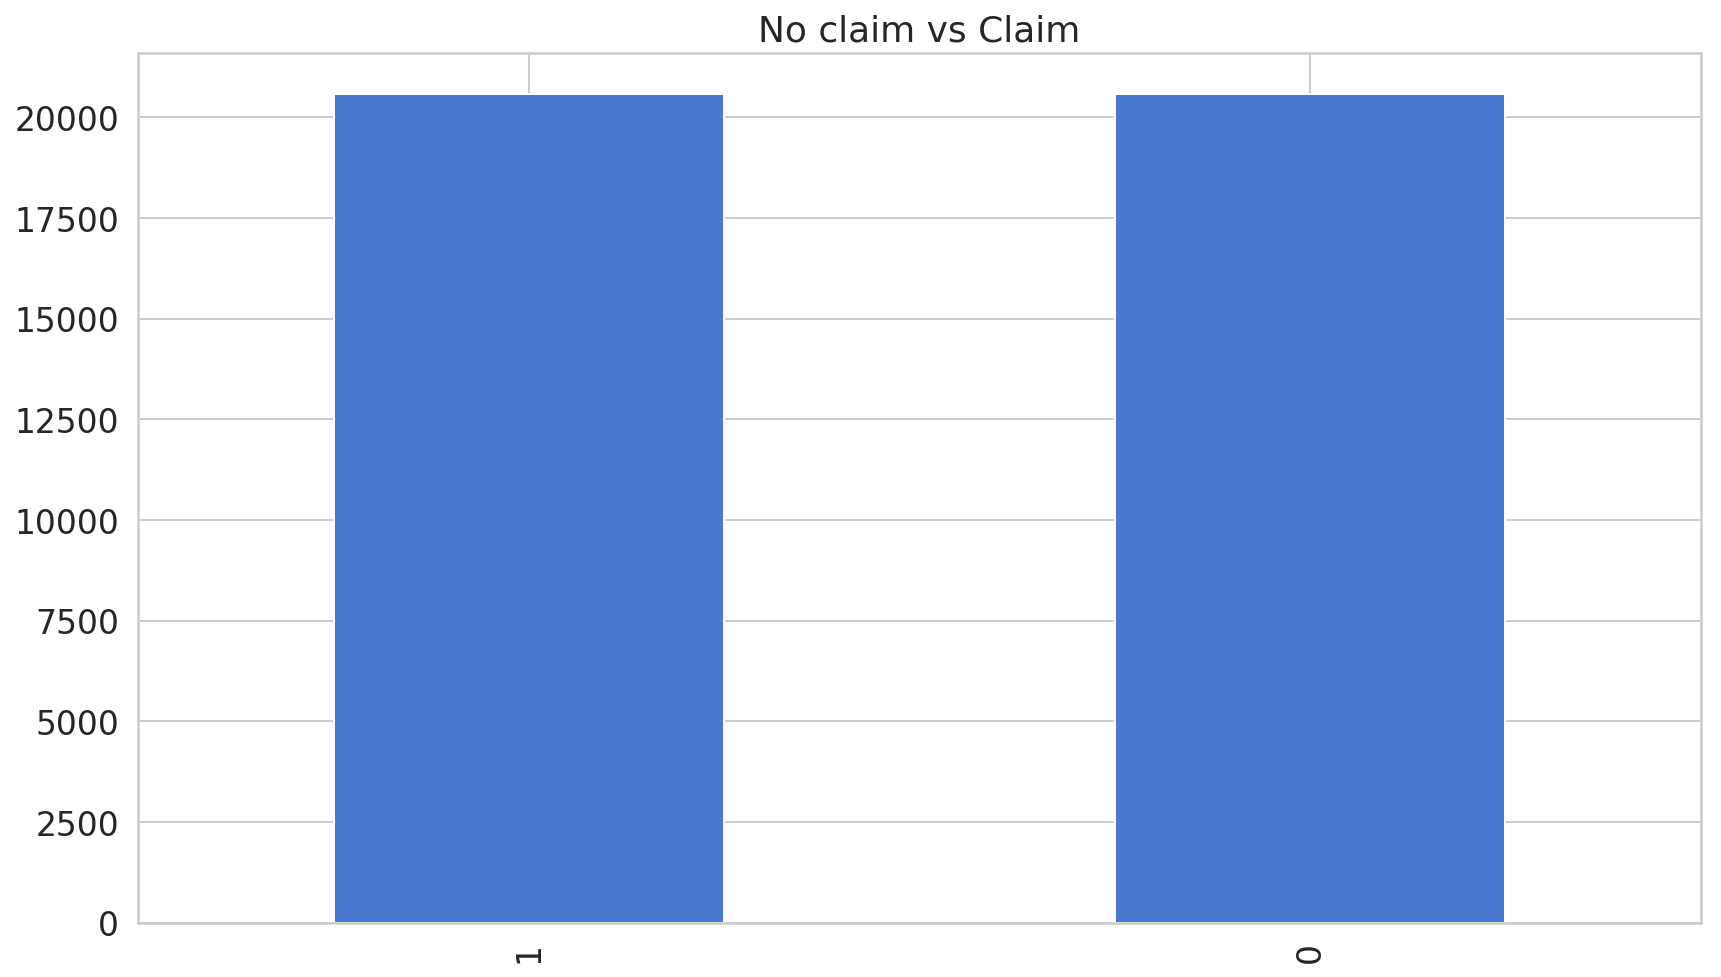

In [65]:
downsampled.target.value_counts().plot(kind="bar", title="No claim vs Claim");

In [0]:
y_train = downsampled.target
X_train = downsampled.drop('target', axis=1)

In [0]:
model = build_model(X_train, metrics=METRICS)

In [68]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

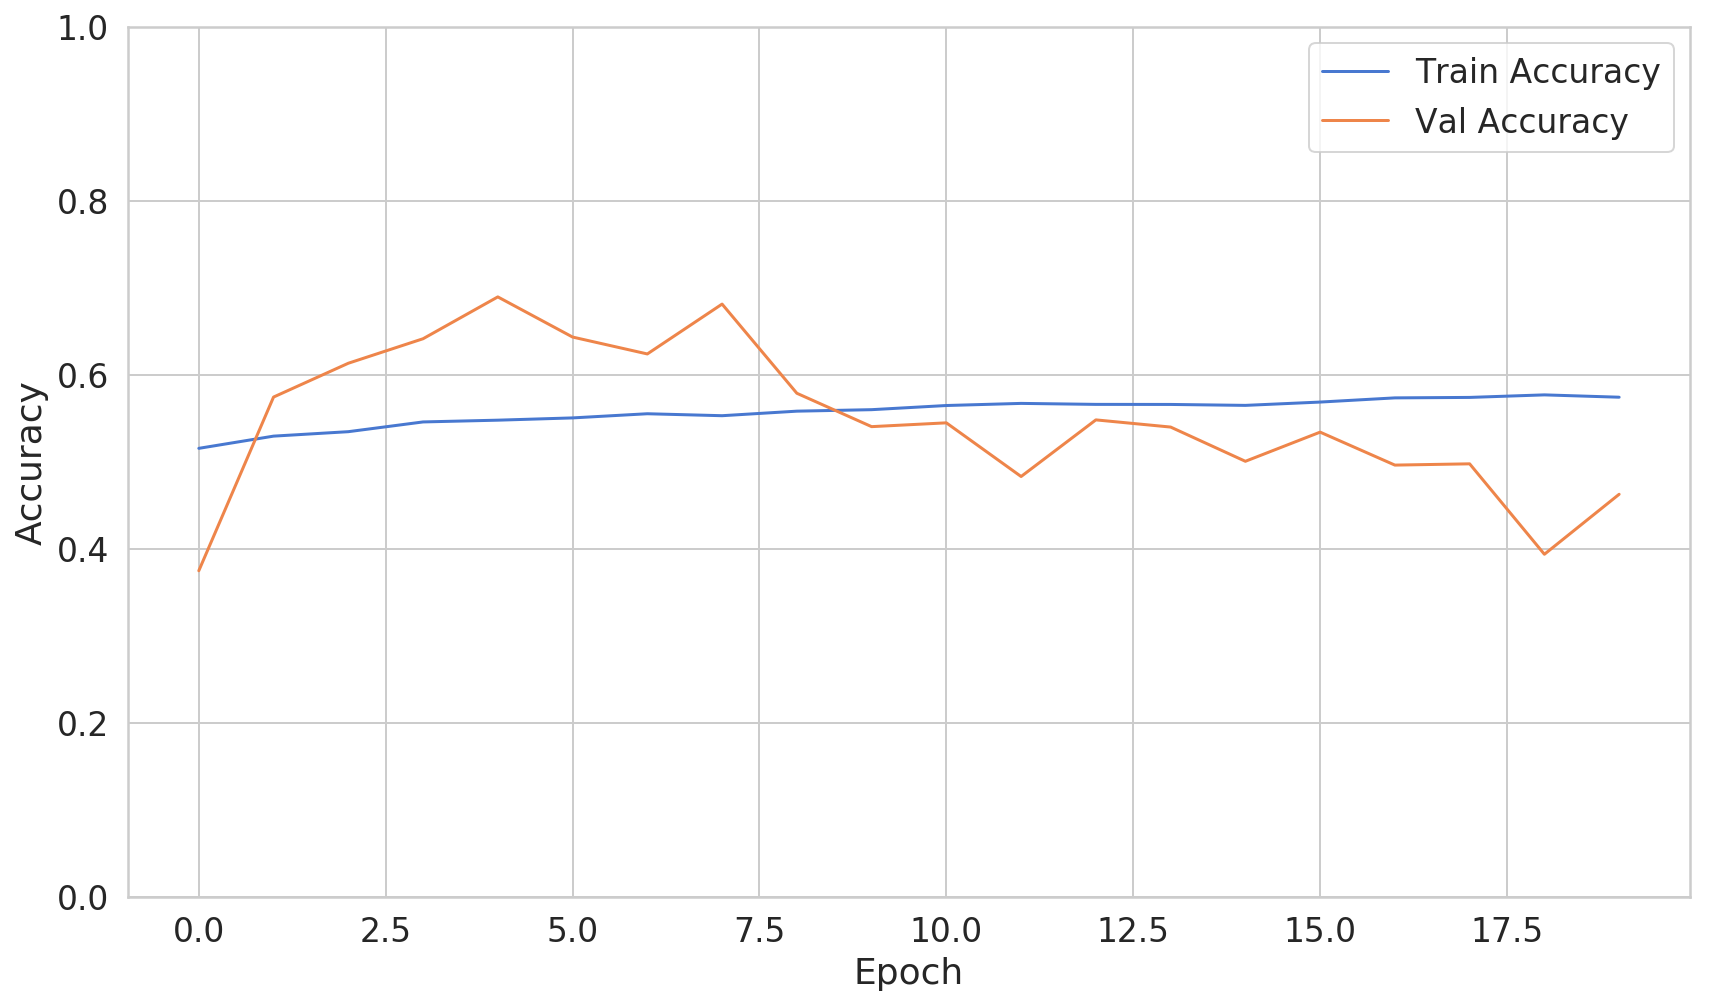

In [69]:
plot_accuracy(history)

In [70]:
model_pred = model.predict(X_test, batch_size=BATCH_SIZE)

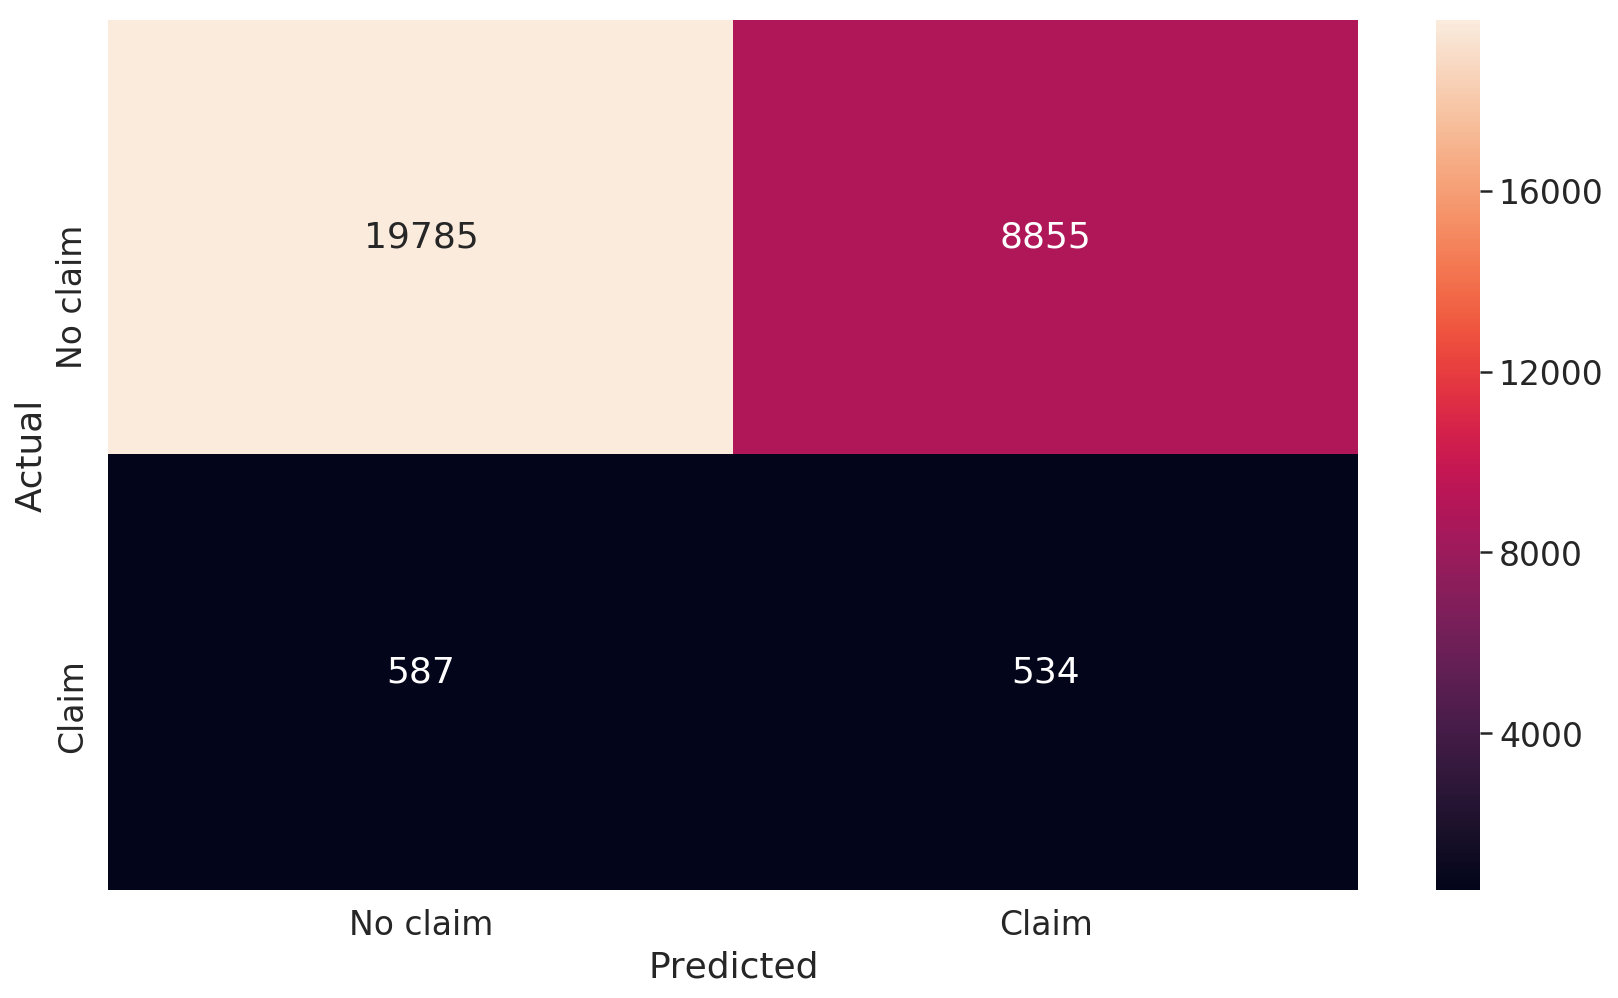

In [71]:
plot_cm(y_test, model_pred)

In [72]:
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.636306811410859
tp :  534.0
fp :  8855.0
tn :  19785.0
fn :  587.0
accuracy :  0.68273914
precision :  0.056875065
recall :  0.47636038
auc :  0.62049145
f1 score: 0.1016175071360609



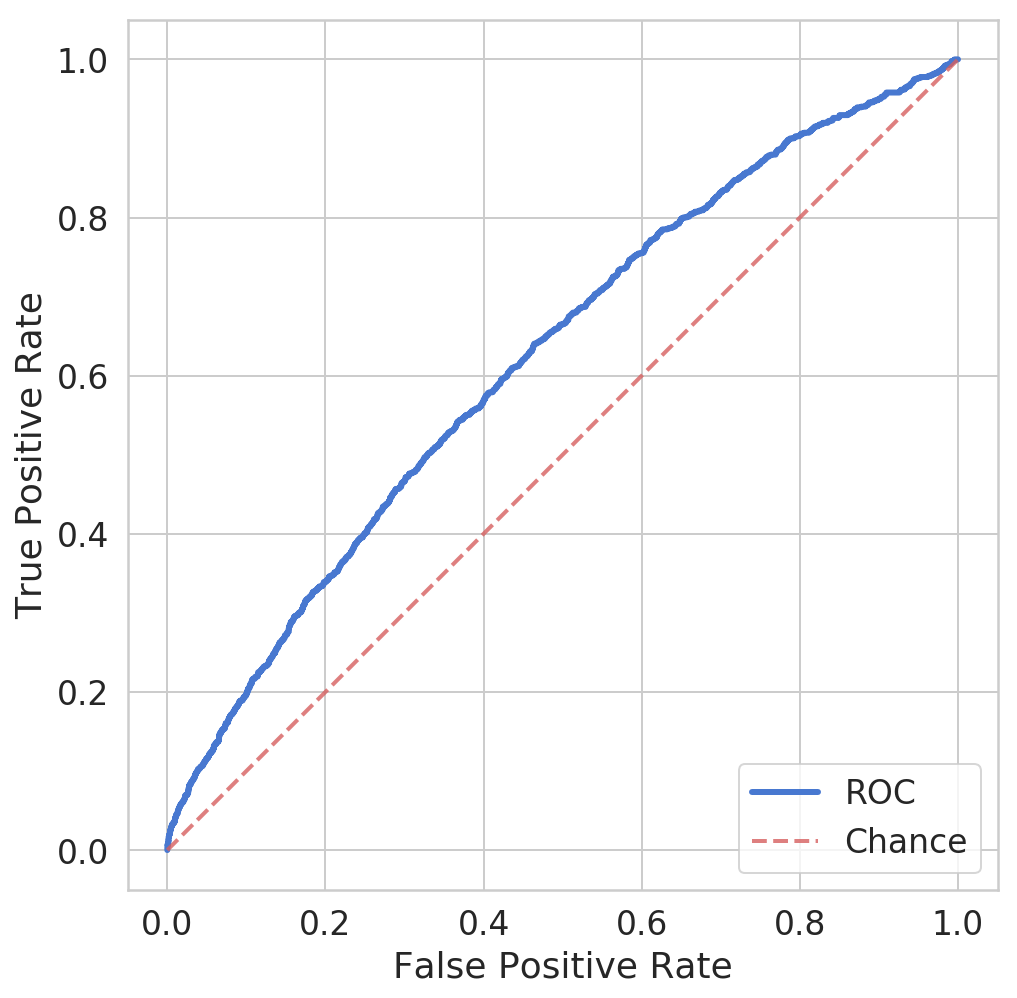

In [73]:
plot_roc(y_test, model_pred)

## Generating synthetic data

In [74]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, ratio=1.0);

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
y_train = X.target
X_train = X.drop('target', axis=1)

In [0]:
X_train, y_train = sm.fit_sample(X_train, y_train)

In [0]:
model = build_model(X_train, metrics=METRICS)

In [0]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.05, 
    shuffle=True,
    verbose=0
)

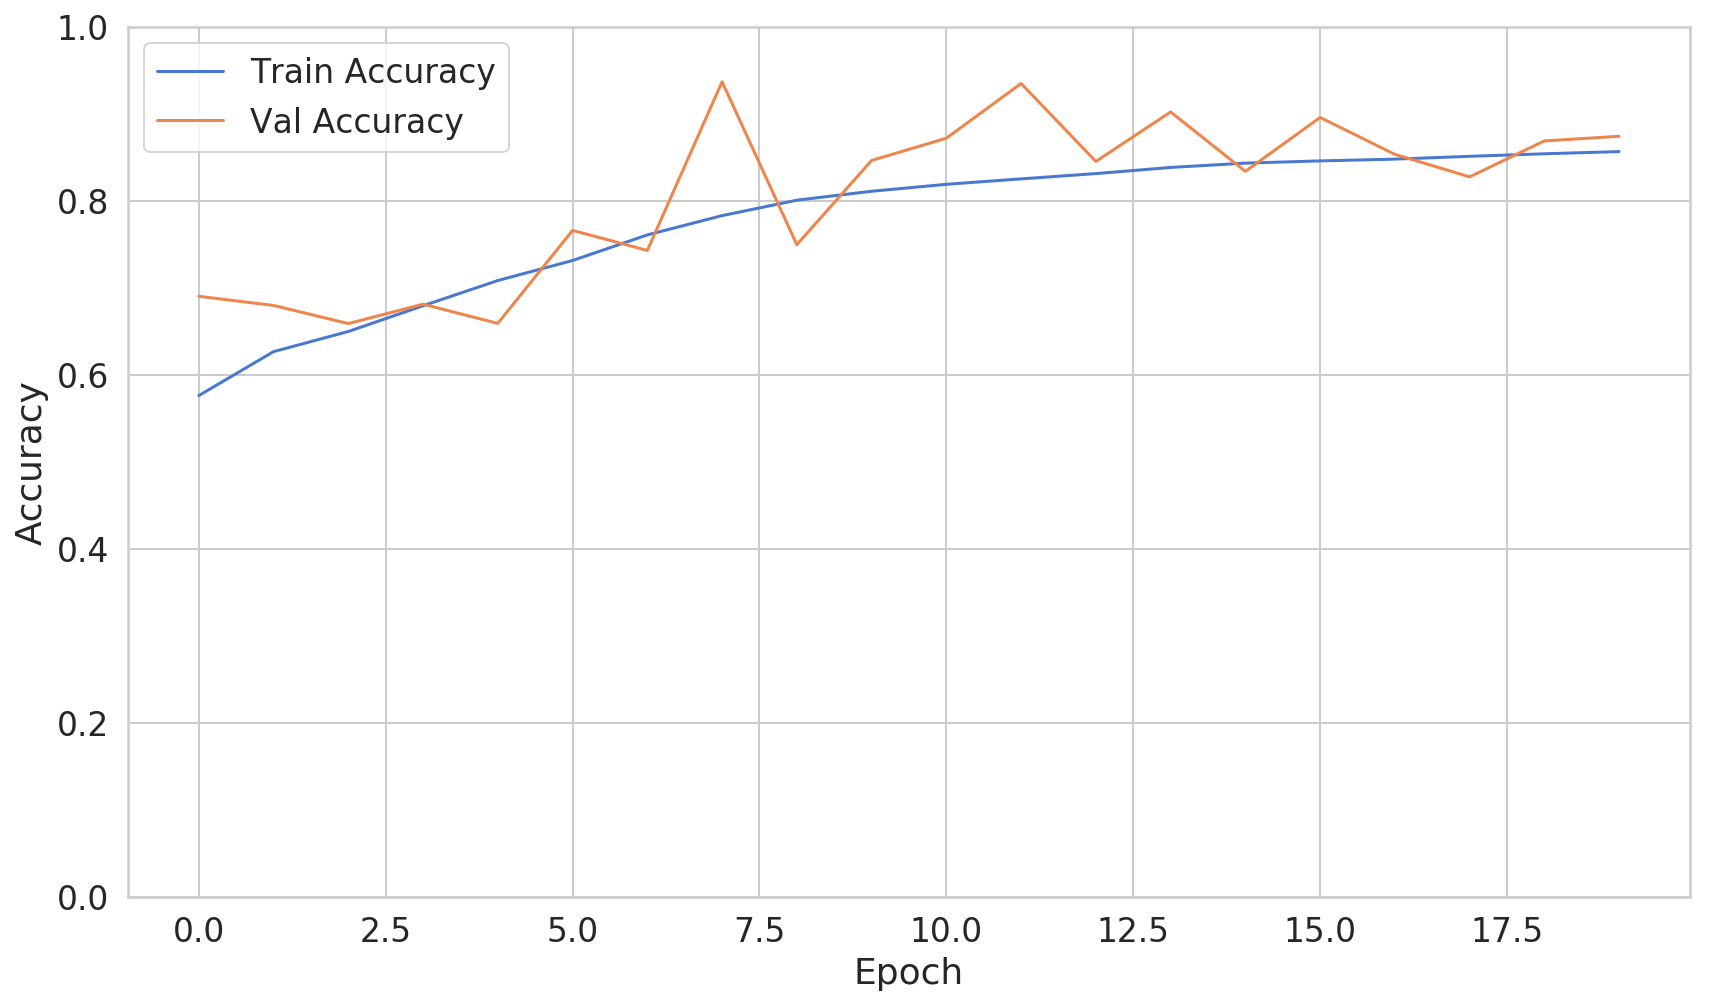

In [79]:
plot_accuracy(history)

In [80]:
model_pred = model.predict(X_test, batch_size=BATCH_SIZE)

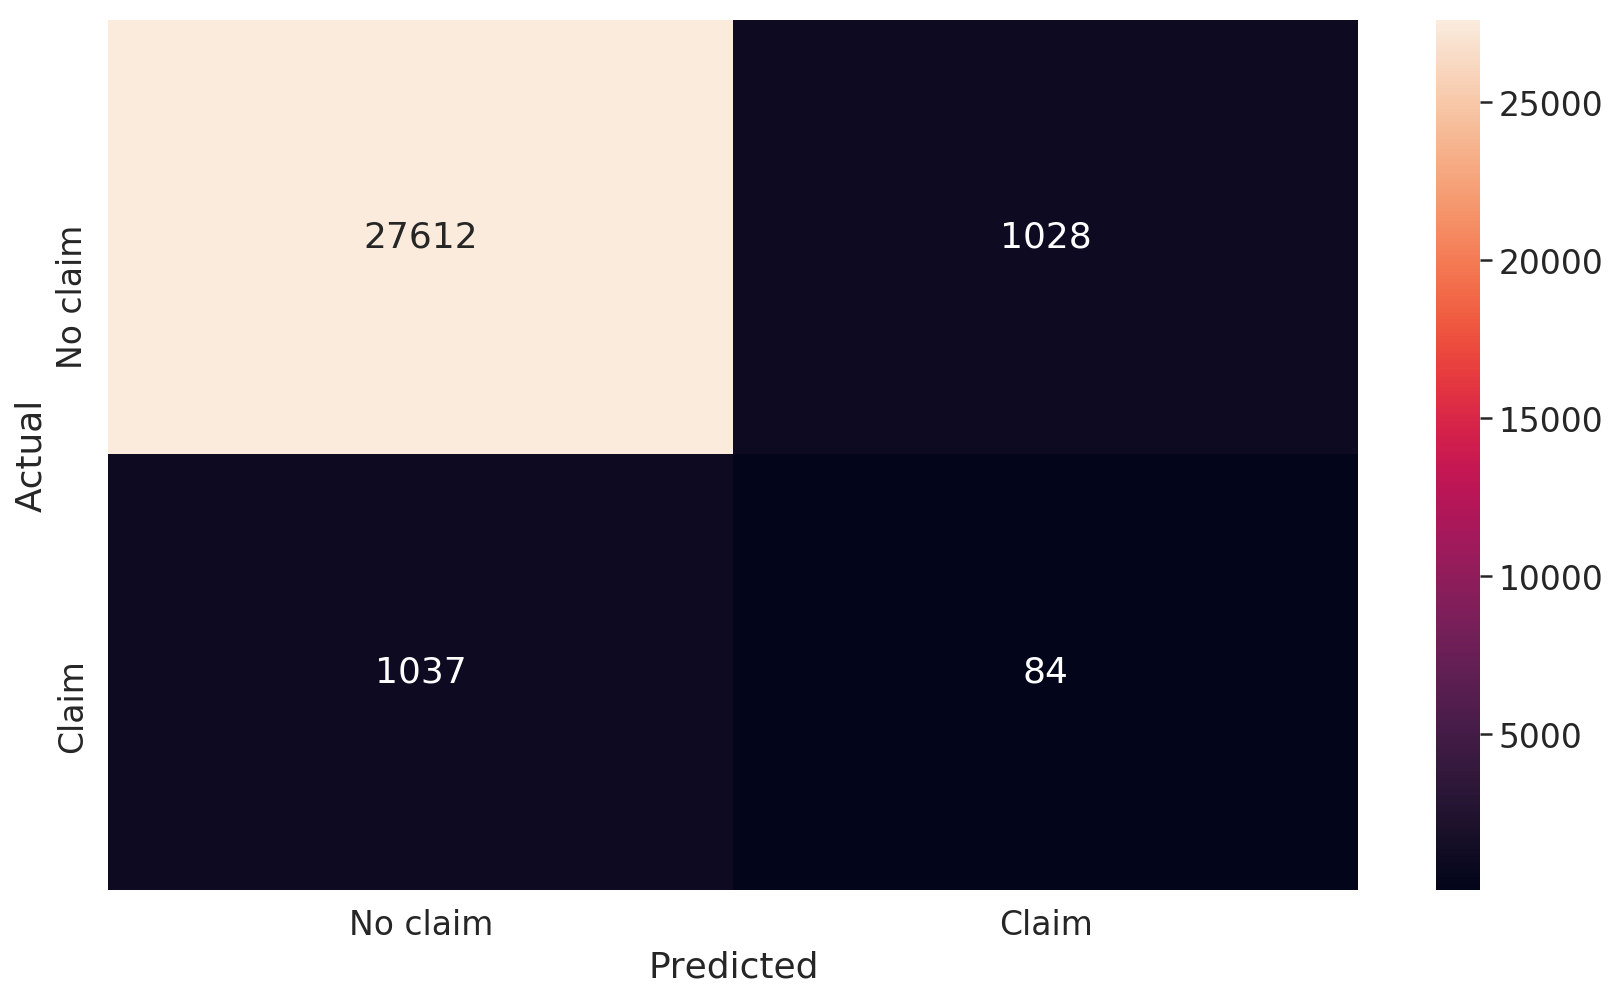

In [81]:
plot_cm(y_test, model_pred)

In [86]:
evaluation_results = model.evaluate(X_test.values, y_test.values, batch_size=BATCH_SIZE, verbose=0)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model, evaluation_results, y_pred)

loss :  0.26040001417683606
tp :  84.0
fp :  1028.0
tn :  27612.0
fn :  1037.0
accuracy :  0.9306139
precision :  0.07553957
recall :  0.0749331
auc :  0.5611229
f1 score: 0.07523510971786834

